<div style="text-align: center;">
    <h1>Alan Joseph</h1>
</div>

## 1. Importing Necessary Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

## 2. Loading the data

In [2]:
train_data = pd.read_csv(r'C:\Users\LENOVO\OneDrive\Desktop\Projects\PA_A2\train.csv').drop(columns='id')
test_data = pd.read_csv(r'C:\Users\LENOVO\OneDrive\Desktop\Projects\PA_A2\test.csv')
credit_risk_data = pd.read_csv(r'C:\Users\LENOVO\OneDrive\Desktop\Projects\PA_A2\credit_risk_dataset.csv')


In [3]:
df_combined=pd.concat([train_data , credit_risk_data])
df_combined=df_combined.drop_duplicates()

In [4]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91061 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91061 non-null  int64  
 1   person_income               91061 non-null  int64  
 2   person_home_ownership       91061 non-null  object 
 3   person_emp_length           90174 non-null  float64
 4   loan_intent                 91061 non-null  object 
 5   loan_grade                  91061 non-null  object 
 6   loan_amnt                   91061 non-null  int64  
 7   loan_int_rate               87966 non-null  float64
 8   loan_percent_income         91061 non-null  float64
 9   cb_person_default_on_file   91061 non-null  object 
 10  cb_person_cred_hist_length  91061 non-null  int64  
 11  loan_status                 91061 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.0+ MB


## 3. EDA

##### Checking the distribution of data in the Target variable 

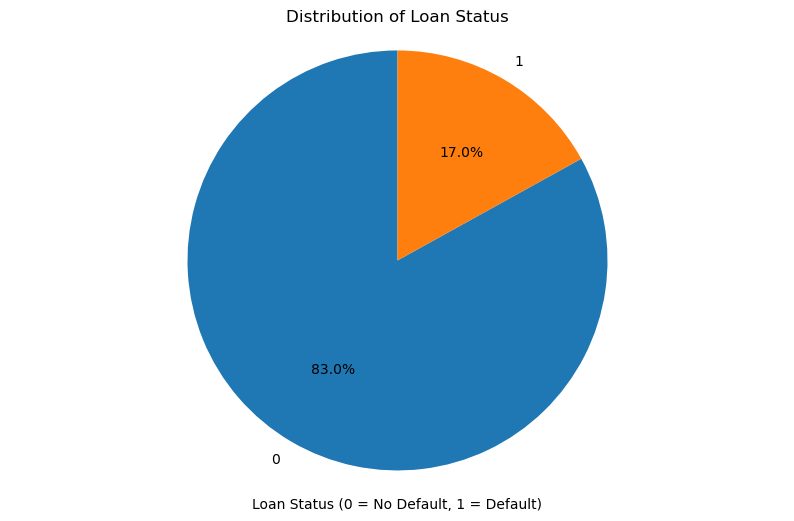

In [5]:
# Calculate value counts for loan status
loan_status_counts = df_combined ['loan_status'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(
    loan_status_counts,
    labels=loan_status_counts.index,
    autopct='%1.1f%%',  
    colors=['#1f77b4', '#ff7f0e'],
    startangle=90,
)
plt.xlabel('Loan Status (0 = No Default, 1 = Default)')
plt.title('Distribution of Loan Status')
plt.axis('equal') 
plt.show()

##### Correlation Heatmap to check if any columns relate to each other

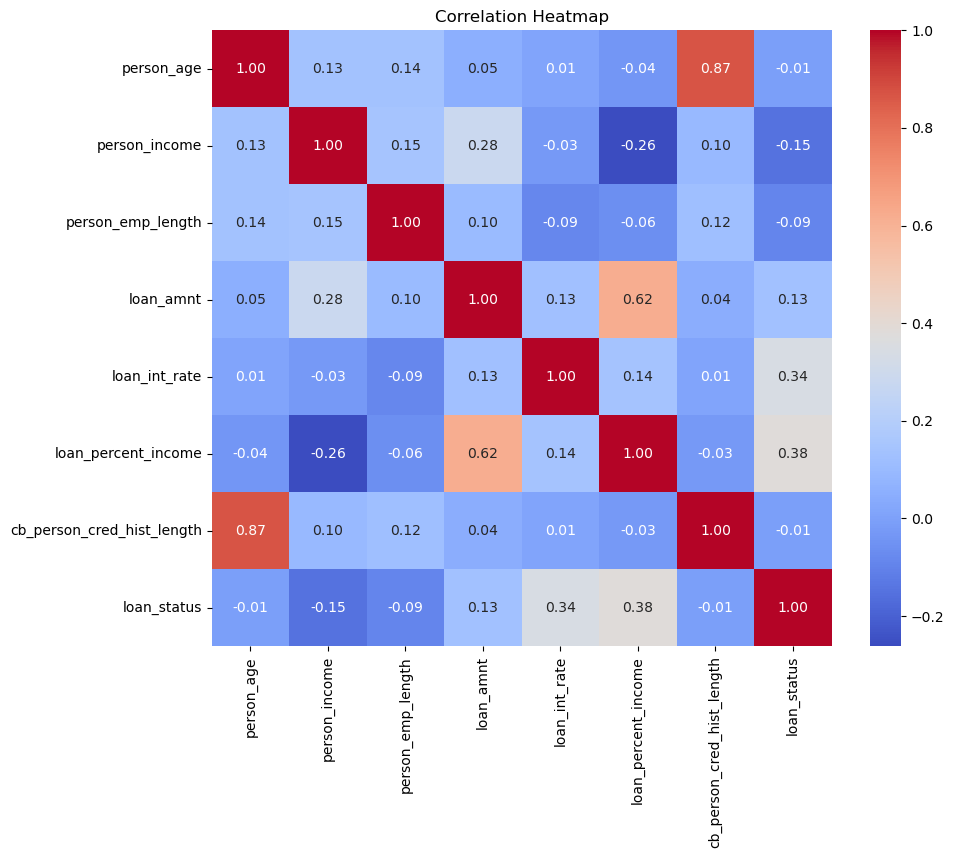

In [6]:
# Select numeric data from the DataFrame
numeric_data = df_combined.select_dtypes(include=(float, int))

# Create a correlation matrix
plt.figure(figsize=(10, 8))
corr = numeric_data.corr()

# Create a heatmap
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## 4. Data Preprocessing

### Missing Values

##### From the above we observe person_emp_length and loan_int_rate have missing values. 

#####  We will now calculate the median of the ratio of employment length to age, and then fill in the missing employment lengths using median ratio and the person's age.

In [7]:
## median ratio
median_person_emp_length = (df_combined.person_emp_length/df_combined.person_age).median()
print(median_person_emp_length)

0.14285714285714285


In [8]:
## Filling in emp length using the calculated median and the given age
df_combined["person_emp_length"]=df_combined["person_emp_length"].fillna(median_person_emp_length*df_combined.person_age)

##### We will now Fill in the missing interest rates using the median interest rates when grouped by loan grade and default on file status.

In [9]:
df_combined["loan_int_rate"] = df_combined.groupby(["loan_grade","cb_person_default_on_file"])["loan_int_rate"].transform(
lambda x: x.fillna(np.round(x.median(),2)))

In [10]:
#Checking for null values after filling in the median
null_loan_int_rate = df_combined[df_combined['loan_int_rate'].isnull()]
print(null_loan_int_rate)

Empty DataFrame
Columns: [person_age, person_income, person_home_ownership, person_emp_length, loan_intent, loan_grade, loan_amnt, loan_int_rate, loan_percent_income, cb_person_default_on_file, cb_person_cred_hist_length, loan_status]
Index: []


### Outlier Detection

##### Assumption 1 for an outlier: Age of a person > 100


In [11]:
# Display rows where person_age > 100
rows_above_100 = df_combined[df_combined['person_age'] > 100]
print(rows_above_100)


       person_age  person_income person_home_ownership  person_emp_length  \
47336         123          36000              MORTGAGE                7.0   
81            144         250000                  RENT                4.0   
183           144         200000              MORTGAGE                4.0   
575           123          80004                  RENT                2.0   
747           123          78000                  RENT                7.0   
32297         144        6000000              MORTGAGE               12.0   

      loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
47336    PERSONAL          B       6700          10.75                 0.18   
81        VENTURE          C       4800          13.57                 0.02   
183     EDUCATION          B       6000          11.86                 0.03   
575     EDUCATION          B      20400          10.25                 0.25   
747       VENTURE          B      20000          10.99           

#####  Removing the above rows containing Outliers

In [12]:
df_combined = df_combined[df_combined.person_age > df_combined.person_emp_length]
df_combined = df_combined[df_combined.person_age < 100]

In [13]:
#Verifying if the outlier has been removed or not
rows_above_100 = df_combined[df_combined['person_age'] > 100]
print(rows_above_100)

Empty DataFrame
Columns: [person_age, person_income, person_home_ownership, person_emp_length, loan_intent, loan_grade, loan_amnt, loan_int_rate, loan_percent_income, cb_person_default_on_file, cb_person_cred_hist_length, loan_status]
Index: []


#####  Assumption 2 for an outlier: person_emp_length >= person_age                  

In [14]:
rows_emp_length_above_age = df_combined[df_combined['person_emp_length'] >= df_combined['person_age']]
print(rows_emp_length_above_age)

Empty DataFrame
Columns: [person_age, person_income, person_home_ownership, person_emp_length, loan_intent, loan_grade, loan_amnt, loan_int_rate, loan_percent_income, cb_person_default_on_file, cb_person_cred_hist_length, loan_status]
Index: []


## 5. Model Building

##### Preparing Data for Modeling

In [15]:
# Define categorical columns
categorical_columns = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'cb_person_default_on_file'
]

In [16]:
# Convert categorical columns to string
for col in categorical_columns:
    df_combined[col] = df_combined[col].astype(str)
    test_data[col] = test_data[col].astype(str)

In [17]:
# Define features and target
X = df_combined.drop(columns=['loan_status'])
y = df_combined['loan_status']

##### Cross-Validation and Model Training

###### We see that we have imbalance in the distribution of data in the target variable, so  using stratified k folds ensures that each fold retains the same ratio of these classes. This helps the model learn effectively from both classes. Using stratified folds leads to more consistent and stable model training and evaluation. 

In [18]:
# Use StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scores = []

for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [19]:
# Define and Train the CatBoost Model with hyperparameters
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,  
    depth=8,              
    cat_features=categorical_columns,
    eval_metric='AUC',
    early_stopping_rounds=50,
    verbose=100
)

model.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	test: 0.8879744	best: 0.8879744 (0)	total: 231ms	remaining: 3m 50s
100:	test: 0.9354408	best: 0.9354408 (100)	total: 7.66s	remaining: 1m 8s
200:	test: 0.9426637	best: 0.9426637 (200)	total: 14.7s	remaining: 58.4s
300:	test: 0.9490250	best: 0.9490250 (300)	total: 22.8s	remaining: 53s
400:	test: 0.9521119	best: 0.9521119 (400)	total: 31.1s	remaining: 46.5s
500:	test: 0.9540706	best: 0.9540927 (496)	total: 39.6s	remaining: 39.5s
600:	test: 0.9553131	best: 0.9553131 (600)	total: 47.9s	remaining: 31.8s
700:	test: 0.9558803	best: 0.9558914 (697)	total: 57s	remaining: 24.3s
800:	test: 0.9564985	best: 0.9564989 (799)	total: 1m 4s	remaining: 16.1s
900:	test: 0.9569393	best: 0.9569413 (895)	total: 1m 12s	remaining: 8s
999:	test: 0.9574017	best: 0.9574166 (996)	total: 1m 20s	remaining: 0us

bestTest = 0.9574165955
bestIteration = 996

Shrink model to first 997 iterations.


## 6. Model Evaluation

In [20]:
y_val_pred = model.predict_proba(X_val)[:, 1]  
roc_auc = roc_auc_score(y_val, y_val_pred)
roc_auc_scores.append(roc_auc)

# Average ROC AUC score
print(f'Average ROC AUC from Cross-Validation: {sum(roc_auc_scores) / len(roc_auc_scores)}')

Average ROC AUC from Cross-Validation: 0.9574165954554082


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

y_val_true = y_val  
y_val_pred = model.predict(X_val) 
y_val_pred_proba = model.predict_proba(X_val)[:, 1] 

# Calculate evaluation metrics
accuracy = accuracy_score(y_val_true, y_val_pred)
precision = precision_score(y_val_true, y_val_pred)
recall = recall_score(y_val_true, y_val_pred)
f1 = f1_score(y_val_true, y_val_pred)
roc_auc = roc_auc_score(y_val_true, y_val_pred_proba)

# Print evaluation metrics
print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_val_true, y_val_pred)
print("\nClassification Report:")
print(class_report)


Model Evaluation Metrics:
Accuracy: 0.9478
Precision: 0.9465
Recall: 0.7338
F1 Score: 0.8267
ROC AUC Score: 0.9574

Confusion Matrix:
[[14994   128]
 [  822  2266]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     15122
           1       0.95      0.73      0.83      3088

    accuracy                           0.95     18210
   macro avg       0.95      0.86      0.90     18210
weighted avg       0.95      0.95      0.95     18210



## 7. Final Model Training and Predictions

In [22]:
# Final model training on the whole training set
final_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    cat_features=categorical_columns,
    eval_metric='AUC',
    early_stopping_rounds=50,
    verbose=100
)

final_model.fit(X, y)


0:	total: 105ms	remaining: 1m 44s
100:	total: 8.76s	remaining: 1m 17s
200:	total: 17.1s	remaining: 1m 7s
300:	total: 26s	remaining: 1m
400:	total: 34.8s	remaining: 52s
500:	total: 43.5s	remaining: 43.4s
600:	total: 53.3s	remaining: 35.4s
700:	total: 1m 2s	remaining: 26.6s
800:	total: 1m 11s	remaining: 17.8s
900:	total: 1m 20s	remaining: 8.79s
999:	total: 1m 28s	remaining: 0us


In [23]:
# Make Predictions on Test Data
y_test_pred = final_model.predict_proba(test_data.drop(columns=['id']))[:, 1]  

# Prepare Submission
submission = pd.DataFrame({
    'id': test_data['id'],
    'loan_status': y_test_pred
})
submission.to_csv('submission.csv', index=False)


In [24]:
submission.head()

,id,loan_status
0,58645,0.998835
1,58646,0.042608
2,58647,0.416313
3,58648,0.011883
4,58649,0.073618


In [25]:
from IPython.display import FileLink

# Create a download link
download_link = FileLink('submission.csv')
download_link

C:\Users\LENOVO\submission.csv